In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix, identity, diags
import scipy.sparse
from scipy.io import mmwrite
from ldpc.codes import rep_code, hamming_code
from bposd.hgp import hgp
from bposd.css import css_code
from ldpc.code_util import construct_generator_matrix, compute_code_parameters, estimate_code_distance, compute_exact_code_distance
from ldpc.mod2 import rank
import networkx as nx
from networkx.algorithms.bipartite import configuration_model, biadjacency_matrix
from matplotlib import rcParams
rcParams['font.size'] = 14
rcParams['text.usetex'] = True

### For creating and coloring check-adjacency graph (Equivalently, bit-adjacency graph of the transpose code)

<p>
  <img src="./Figs/becolor.svg" alt="Bit-Edge coloring" width="500">
</p>

**(a)** Tanner graph example for $H=\begin{pmatrix} 1 & 1 & 0 \\ 0 & 1 & 1 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}$.

**(b)** Tanner graph for $H^T=\begin{pmatrix} 1 & 0 & 0 & 0 \\ 1 & 1 & 1 & 0 \\ 0 & 1 & 0 & 1 \end{pmatrix}$. 

**(c)** Check-adjacency graph for the Tanner graph in (a), where edges between vertices exist iff corresponding checks share a common bit. Equivalently, the bit-adjacency graph for the Tanner graph in (b). Edges exist between vertices iff corresponding bits share a common check. 

**(d)** Example coloring of the graph in (c). Vertices in the same color mean that their corresponding checks in (a) do not share a bit in common, and that their corresponding bits in (b) do not share a check in common.

**(e)** Correlation between the colors in (d) and the checks of (a), where checks in the same color do not share a bit in common.


In [2]:
def get_check_adj_graph(H):
    A = (H @ H.T != 0).astype(int) # #checks x #checks; 1 if checks share a bit; 0 otherwise
    np.fill_diagonal(A, 0)
    G = nx.from_numpy_array(A, create_using=nx.Graph())
    return G


def get_check_coloring(H):
    G = get_check_adj_graph(H)
    color_dict = nx.greedy_color(G, strategy='independent_set')
    
    num_colors = max(list(color_dict.values())) + 1
    coloring = []
    for i in range(num_colors):
        coloring.append([key for key, value in color_dict.items() if value == i])
    return coloring

### Creating the random classical LDPC code

**Enforcing full rank here***

In [3]:
n = 30 # #bits

# LDPC params
d_v = 5 # how many checks each bit participates in
d_c = 6 # how many bits each check involves
min_dist = 13
max_coloring = 9

for i in range(10000):
    m = int(n * d_v / d_c) # #checks
    graph = configuration_model(
        d_v*np.ones(n,dtype=int), 
        d_c*np.ones(m,dtype=int), 
        create_using=nx.Graph())
    H = biadjacency_matrix(graph, row_order=np.arange(n)).T.toarray()
    d = compute_exact_code_distance(H)
    #print(f"distance: {d}")
    if d >= min_dist and rank(H) == H.shape[0]: #*
        coloring = get_check_coloring(H)
        print(f"# colors: {len(coloring)}")
        if len(coloring)<=max_coloring:
            break
print(f"[n, k, d] = {compute_code_parameters(H)}")

/home/aarav/miniforge3/envs/quantum/lib/python3.11/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


# colors: 9
[n, k, d] = (30, 5, 13)


### Reading the Tanner graph
- Left set of nodes are the bits; right set of nodes are the checks

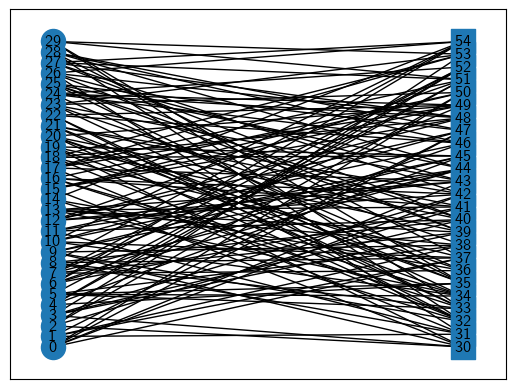

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

vars = list(range(n))
checks = [v for v in graph.nodes() if v not in vars]

pos = nx.bipartite_layout(graph, vars)

nx.draw_networkx_nodes(graph, pos, nodelist=vars, node_shape='o')
nx.draw_networkx_nodes(graph, pos, nodelist=checks, node_shape='s')
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos)

plt.show()


### Coloring the classical checks

- `coloring[i]` contains the bit(s) in color group `i`
- Example:
$$\big[\underbrace{[8, 1, 4, 7]}_{\rm group\ 0}, \underbrace{[0, 3, 6]}_{\rm group\ 1}, \underbrace{[2]}_{\rm group\ 2}, \underbrace{[5]}_{\rm group\ 3}\big]$$

* color group 0: bit(s) 8, 1, 4, 7
* color group 1: bit(s) 0, 3, 6
* color group 2: bit(s) 2
* color group 3: bit(s) 5

<p>
  <img src="./Figs/classicalcolor.svg" alt="Classical coloring" width="400">
</p>

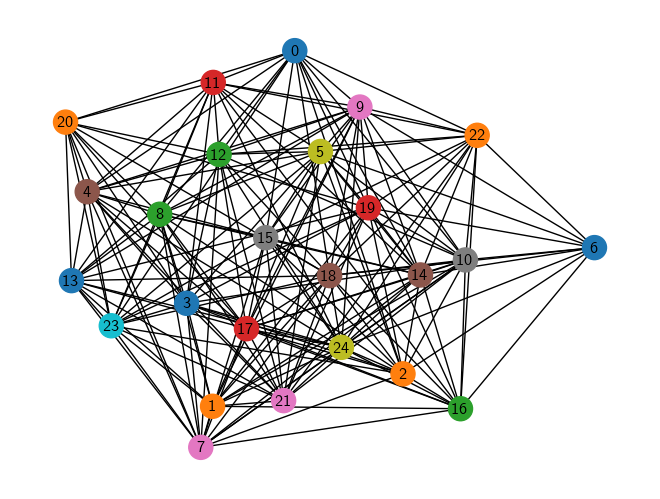

In [18]:
### Coloring + checks
coloring = get_check_coloring(H)
#print(f"Check coloring: {coloring}")
G_checks = get_check_adj_graph(H)

# creating colors for viz
color_map = {}
for color_idx, group in enumerate(coloring):
    for check in group:
        color_map[check] = color_idx
node_colors = [color_map[i] for i in G_checks.nodes()]

pos = nx.spring_layout(G_checks, seed=0)
nx.draw(G_checks, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.tab10)
plt.show()

### Hypergraph Product

<p>
  <img src="./Figs/hgp.svg" alt="HGP" width="300">
</p>
Edges omitted.

In [6]:
code = hgp(h1=H, h2=H, compute_distance=True)
code.name = 'HGP Random'
code.test()

HGP Random
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -HGP Random is a valid CSS code w/ params [1525,25,13]


/home/aarav/miniforge3/envs/quantum/lib/python3.11/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


True

**Prints check-type Tanner graph.**

Tanner graph (contains X and Z stabilizers) for check-type qubits ONLY

In [7]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt

# ctype_start_idx : index of first check-type qubit
# ctypes : set of check-type qubit indices to include in the graph
def ctype_tannergraph(hx, hz, ctype_start_idx, ctypes):
    N = hx.shape[1]
    mx = hx.shape[0]
    mz = hz.shape[0]

    ctype_cols = np.arange(ctype_start_idx, N)
    ctype_set = set(ctype_cols.tolist())
    q_nodes = list(ctype_cols)
    x_nodes = list(range(N, N + mx))
    z_nodes = list(range(N + mx, N + mx + mz))
    G = nx.Graph()
    G.add_nodes_from(q_nodes,  bipartite=0, kind='qubit')
    G.add_nodes_from(x_nodes,  bipartite=1, kind='X')
    G.add_nodes_from(z_nodes,  bipartite=1, kind='Z')

    # hx edges
    coords = hx.tocoo()
    for r, c, v in zip(coords.row, coords.col, coords.data): 
        if v % 2 != 0 and c in ctype_set and c in ctypes:
            G.add_edge(N + r, c)

    # hz edges
    coords = hz.tocoo()
    for r, c, v in zip(coords.row, coords.col, coords.data):
        if v % 2 != 0 and c in ctype_set and c in ctypes: # just looking at one qubit
            G.add_edge(N + mx + r, c)

    pos = nx.bipartite_layout(G, q_nodes)
    nx.draw_networkx_nodes(G, pos, nodelist=q_nodes, node_shape='o', node_color='lightgreen', label='check-type qubits')
    nx.draw_networkx_nodes(G, pos, nodelist=x_nodes, node_shape='s', node_color='salmon', label='X stabilizers')
    nx.draw_networkx_nodes(G, pos, nodelist=z_nodes, node_shape='s', node_color='lightblue', label='Z stabilizers')
    nx.draw_networkx_edges(G, pos, alpha=0.6)
    labels = {q: f"q{q}" for q in q_nodes}
    labels.update({N + r: f"X{r}" for r in range(mx)})
    labels.update({N + mx + r: f"Z{r}" for r in range(mz)})
    nx.draw_networkx_labels(G, pos, labels, font_size=6)
    plt.show()

# Reduction

### 1. Isolate color groups
* Sector check-type qubits into color groups:
* Output: a dict. 
    - Key: color group index
    - Value: list of qubit coordinates in that color groups.

<p>
  <img src="./Figs/hgpexcolor.svg" alt="HGP" width="400">
</p>

Color groups are 0-indexed reading left-to-right top-to-bottom (group 0 is red-red, group 1 is blue-red, etc.)

Qubits are 0-indexed by coordinate system with origin at the top-left increasing left-to-right top-to-bottom (e.g., the 4 qubits in color group 0 have coordinates (0, 0), (0, 1), (1, 0), (1, 1))

Then, 
$$\begin{aligned}\texttt{color\_groups = } \{&0 : [(0, 0), (0, 1), (1, 0), (1, 1)], \\ &1 : [(0, 2), (1, 2)], \\ &2 : [(0, 3), (0, 4), (1, 3), (1, 4)], \\ &3 : [(2, 0), (2, 1)], \\ &4 : [(2, 2)], \\ &5 : [(2, 3), (2, 4)], \\ &6 : [(3, 0), (3, 1), (4, 0), (4, 1)], \\ &7 : [(3, 2), (4, 2)], \\ &8 : [(3, 3), (3, 4), (4, 3), (4, 4)]\}\end{aligned}$$

In [8]:
print(f"HGP Code parameters: [[{code.N}, {code.K}, {code.D}]]")

m, n = H.shape
bit_type = np.arange(0, n*n)
check_type = np.arange(n*n, n*n + m*m)

#print(f"Check-type indices: {check_type}")
#print(f"Classical check coloring: {coloring}")

color_groups = {}
for group1 in coloring:
    for group2 in coloring:
        length = len(color_groups)
        color_groups[length] = []
        for c1 in group1:
            for c2 in group2:
                color_groups[length].append((c1, c2))
        
#print(f"HGP color groups indexed by qubit coordinate: {color_groups}")
    

HGP Code parameters: [[1525, 25, 13]]


### 2. Setting up the transformation for combining per-qubit stabilizers:

**Round 1:**
- Color groups are defined by indices `0`, `1`, `2`, `3`, `...`, `len(color_groups)-1`
- First parallel round:
    * combine $Z$ on color groups `0`, `len(coloring) + 1`, `2*len(coloring) + 2`, `3*len(coloring) + 3`, `...`, 
    * combine $X$ on color groups `1`, `len(coloring)`, `2*len(coloring) + 3`, `3*len(coloring) + 2`, `...`,

<p>
  <img src="./Figs/hgpexremove.svg" alt="HGP" width="400">
</p>

Let the purple numbers next to $X$ stabilizers indicate the index of the corresponding row of that stabilizer in $H_X$. Let the orange number inside each color group denote the index of that color group in $\texttt{color\_groups}$. We combine $X$ stabilizers in groups 0, 4, 8; and combine $Z$ stabilizers in groups 1, 3.

Coordinate $(a, b)$ corresponds to qubit index $n^2 + ma + b$ in $H_X$ and $H_Z$. For example, the qubit with connected stabilizer edges in the above figure is coordinate $(1, 1)$. Since $n=m=5$, we have that it's index is $5^2 + 5(1) + 5 = 35$. Then, $\texttt{stabs\_touching\_qubit(Hx, 35) = [5, 6, 8]}$ (indices of $X$ stabilizers connected to that qubit). As per the transformation, we then combine stabilizers 5 and 6, then 6 and 8 (repetition-code style). We do this by calling $\texttt{combinerowsF2(Hx, [5, 6, 8])}$. This will remove $X$ support off qubit $(1, 1)$. We can then cut $Z$ support and discard the qubit.

In [9]:
def stabs_touching_qubit(H, q):
    """
    Returns the indices of the stabilizers that touch a given qubit index.
    """
    return H[:, q].nonzero()[0]

def combinerowsF2(H, stab_indices):
    """
    For each i in stab_indices, combines rows H[i] and H[i+1] over F2. 
    
    H : PCM (code.hx or code.hz)
    stab_indices : indices of rows to be combined repetition-code style
    """
    #if len(stab_indices) < 2:
        #return H
    
    stab_indices = list(stab_indices)

    for k in range(len(stab_indices) - 1):
        i = stab_indices[k]
        j = stab_indices[k + 1]

        ri = H.getrow(i).toarray()[0]
        rj = H.getrow(j).toarray()[0]

        H[i, :] = (ri ^ rj).astype(int)  # add over F2

    # delete last stabilizer row
    last_row = stab_indices[-1]
    m, n = H.shape
    keep_rows = [r for r in range(m) if r != last_row]

    H_new = H[keep_rows, :][:, :].tocsr()
    return H_new


### Optimization
* Re-arranging the color groups so that the groups that we combine have the most qubits. Will allow us to remove the most check-type qubits.

<p>
  <img src="./Figs/hgpexpreoptimized.svg" alt="HGP" width="400">
</p>

We previously said that we combine $X$ stabilizers in groups 0, 4, 8; and combine $Z$ stabilizers in groups 1, 3, 5, 7. However, this does not remove the optimal number of check-type qubits, since we leave color groups 2 and 6 untouched when they have 4 check-type qubits.

**Optimization:**
* If we order the color groups in terms of the number of check-type qubits, we get: `[0, 2, 6, 8, 1, 3, 5, 7, 4]`. This is what $\texttt{sorted\_indices}$ holds. 
* We combine 5 total color groups, and so the 5 largest color groups are `[0, 2, 6, 8, 1]` (what $\texttt{top}$ holds). We should not combine on groups `[3, 5, 7, 4]` (what $\texttt{rest}$ holds).
* Before, we were going to combine on $\texttt{Xcombines = [0, 4, 8]}$ and $\texttt{Zcombines = [1, 3]}$.
* To optimize, we send:
```python
new_color_groups[0] = old_color_groups[0]
new_color_groups[4] = old_color_groups[2]
new_color_groups[8] = old_color_groups[6]
new_color_groups[1] = old_color_groups[8]
new_color_groups[3] = old_color_groups[1]
```
(and assign old groups 3, 5, 7, 4 to the remaining)
which gets us:

<p>
  <img src="./Figs/hgpexoptimized.svg" alt="HGP" width="400">
</p>

### Uh this shouldn't work. lol. But it does?

In [10]:
# combine Z on color groups 0, len(coloring) + 1, 2*len(coloring) + 2, 3*len(coloring) + 3, ...,
# combine X on color groups 1, len(coloring), 2*len(coloring) + 3, 3*len(coloring) + 2, ...,
Zcombines = [i*len(coloring) + i for i in range(len(coloring))]
Xcombines = [i*len(coloring) + (i+1 if i%2 == 0 else i-1) for i in range(len(coloring) - 1)]

old_groups = color_groups.copy()
all_indices = list(color_groups.keys())

# indices of the color groups that we combine
# these are the indices where we want the largest groups to live after optimization
targets = list(dict.fromkeys(Xcombines + Zcombines)) 
num_targets = len(targets)

# sort group indices by group size
sorted_indices = sorted(all_indices, key=lambda idx: len(color_groups[idx]), reverse=True)

top = sorted_indices[:num_targets]
rest = sorted_indices[num_targets:]
new_color_groups = {}

# send biggest groups to target indices 
for src_idx, target_idx in zip(top, targets):
    new_color_groups[target_idx] = color_groups[src_idx]

# send remaining groups to the non-target indices
non_targets = [idx for idx in all_indices if idx not in targets]
for src_idx, target_idx in zip(rest, non_targets):
    new_color_groups[target_idx] = color_groups[src_idx]

color_groups = new_color_groups
    
#print(f"Xcombines: {Xcombines}")
#print(f"Zcombines: {Zcombines}")
        
# for key, elem in color_groups.items():
#     if key in Zcombines:
#         print(f"NEW: Z-combined group {key} has {len(elem)} items.")
#     elif key in Xcombines:
#         print(f"NEW: X-combined group {key} has {len(elem)} items.")
#     else:
#         print(f"NEW: Non-combined group {key} has {len(elem)} items.")
        
# for key, elem in old_groups.items():
#     if key in Zcombines:
#         print(f"OLD: Z-combined group {key} has {len(elem)} items.")
#     elif key in Xcombines:
#         print(f"OLD: X-combined group {key} has {len(elem)} items.")
#     else:
#         print(f"OLD: Non-combined group {key} has {len(elem)} items.")

### Test
* Trying to combine Z stabilizers on the first check-type qubit
* Might take some time to run

Pre-Z transformation


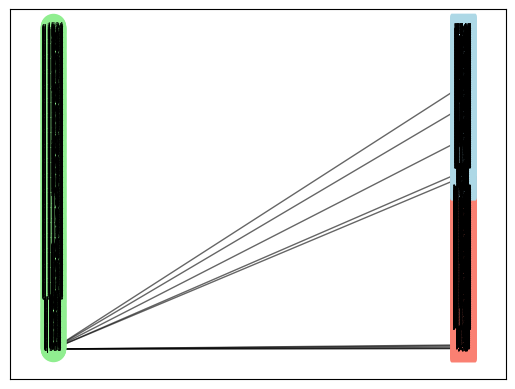

/home/aarav/miniforge3/envs/quantum/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Post-Z transformation


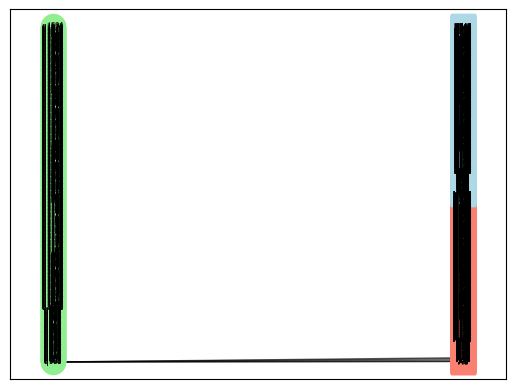

In [11]:
print("Pre-Z transformation")
ctype_tannergraph(code.hx, code.hz, n**2, [n**2])
Hznew = combinerowsF2(code.hz, stabs_touching_qubit(code.hz, n**2))
print("Post-Z transformation")
ctype_tannergraph(code.hx, Hznew, n**2, [n**2])

### 3. Combine color-group stabilizers (round 1)

Pre-Z transformation


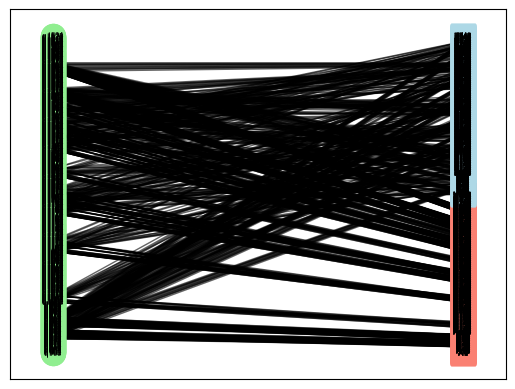

Post-Z transformation


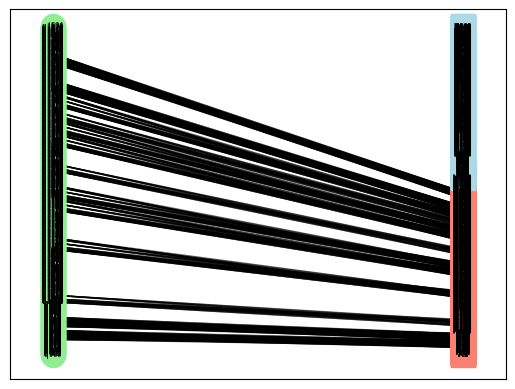

Pre-X transformation


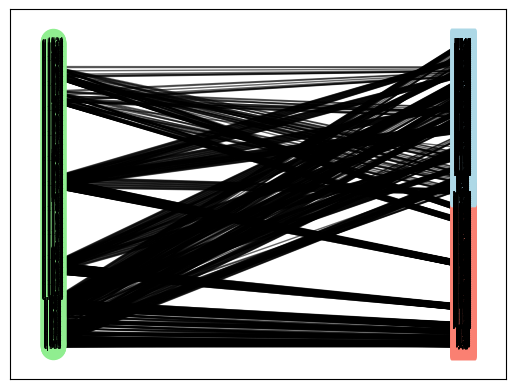

Post-X transformation


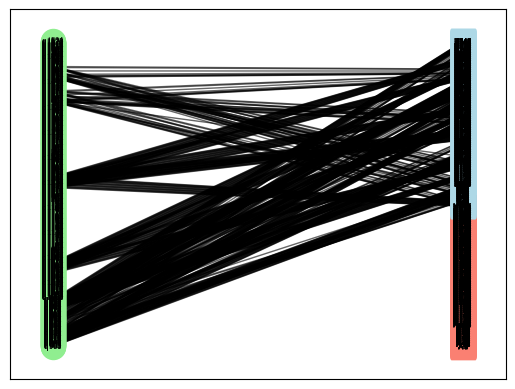

In [12]:
# Before the Z transformation
Zgroups = [n**2 + (m*c1 + c2) for g in Zcombines for (c1, c2) in color_groups[g]] # qubit idx at coord (a, b) is (n**2) + (ma + b)
print("Pre-Z transformation")
ctype_tannergraph(code.hx, code.hz, n**2, Zgroups)

# Z transformation
Hznew = code.hz.copy()
for Zcolorgroup in Zcombines:
    #print(f"--- COMBINING Z IN COLOR GROUP {Zcolorgroup} ---")
    for (c1, c2) in color_groups[Zcolorgroup]:
        #print(f"qubit coordinate = ({c1}, {c2})")
        #print(f"qubit index = {n**2 + (m*c1 + c2)}")
        Hznew = combinerowsF2(Hznew, stabs_touching_qubit(Hznew, n**2 + m*c1 + c2))
print("Post-Z transformation")
ctype_tannergraph(code.hx, Hznew, n**2, Zgroups)

# Before the X transformation
Xgroups = [n**2 + (m*c1 + c2) for g in Xcombines for (c1, c2) in color_groups[g]] # qubit idx at coord (a, b) is (n**2) + (ma + b)
print("Pre-X transformation")
ctype_tannergraph(code.hx, code.hz, n**2, Xgroups)

# X transformation
Hxnew = code.hx.copy()
for Xcolorgroup in Xcombines:
    #print(f"--- COMBINING X IN COLOR GROUP {Xcolorgroup} ---")
    for (c1, c2) in color_groups[Xcolorgroup]:
        #print(f"qubit coordinate = ({c1}, {c2})")
        #print(f"qubit index = {n**2 + (m*c1 + c2)}")
        Hxnew = combinerowsF2(Hxnew, stabs_touching_qubit(Hxnew, n**2 + m*c1 + c2)) # qubit idx at coord (a, b) is (n**2) + (ma + b)
print("Post-X transformation")
ctype_tannergraph(Hxnew, code.hz, n**2, Xgroups)


* Cut $X\ (Z)$ support on check-type qubits that we combined $Z\ (X)$ stabilizers on. Removes all support to discard the check-type qubit.

In [13]:
for Zcolorgroup in Zcombines:
    #print(f"--- REMOVING ALL X SUPPORT IN COLOR GROUP {Zcolorgroup} ---")
    for (c1, c2) in color_groups[Zcolorgroup]:
        q = n**2 + (m*c1 + c2)
        #print(f"qubit coordinate = ({c1}, {c2})")
        #print(f"qubit index = {q}")
        Hxnew[:, q] = 0

for Xcolorgroup in Xcombines:
    #print(f"--- REMOVING ALL Z SUPPORT IN COLOR GROUP {Xcolorgroup} ---")
    for (c1, c2) in color_groups[Xcolorgroup]:
        q = n**2 + (m*c1 + c2)
        #print(f"qubit coordinate = ({c1}, {c2})")
        #print(f"qubit index = {q}")
        Hznew[:, q] = 0

Remove check-type qubits that lost support and thus we can discard.

In [14]:
def remove_supportless(H):
    H = H.tocsr(copy=True)
    H.eliminate_zeros()
    col_nnz = H.getnnz(axis=0) 
    keep_idx = np.where(col_nnz > 0)[0]
    return H[:, keep_idx]

Hxnew = remove_supportless(Hxnew)
Hznew = remove_supportless(Hznew)

### Check transformation validity

In [15]:
#np.set_printoptions(threshold=np.inf, linewidth=200)
print("Old # of X stabilizers:", code.hx.shape[0])
print("New # of X stabilizers:", Hxnew.shape[0])
print("Old # of Z stabilizers:", code.hz.shape[0])
print("New # of Z stabilizers:", Hznew.shape[0])
print("Old number of check-type qubits:", code.hx.shape[1] - n**2)
print("New number of check-type qubits:", Hxnew.shape[1] - n**2)

print(Hxnew.shape, Hznew.shape)

print("****** NEW CODE TEST ******")
newcode = css_code(hx=Hxnew, hz=Hznew)
newcode.name = 'Transformed code'
newcode.test()

print("****************************************")
print(f"[[n, k, d]] = [[{code.N}, {code.K}, {code.D}]]")
print(f"[[n', k', d']] = [[{newcode.N}, {newcode.K}, {code.D}]]")
#print(newcode.compute_code_distance())

Old # of X stabilizers: 750
New # of X stabilizers: 638
Old # of Z stabilizers: 750
New # of Z stabilizers: 642
Old number of check-type qubits: 625
New number of check-type qubits: 405
(638, 1305) (642, 1305)
****** NEW CODE TEST ******
Transformed code
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -Transformed code is a valid CSS code w/ params [1305,25,nan]
****************************************
[[n, k, d]] = [[1525, 25, 13]]
[[n', k', d']] = [[1305, 25, 13]]


$\big(\bar{w}_q, \bar{w}_c\big)_X$ and $\big(\bar{w}_q^\prime, \bar{w}_c^\prime\big)_X$

In [16]:
def avg_deg(H):
    return np.floor(H.getnnz(axis=0).mean()*1000)/1000, np.floor(H.getnnz(axis=1).mean()*1000)/1000

print(f"Original (w_q, w_c)_X: {avg_deg(code.hx)}")
print(f"Transformed (w'_q, w'_c)_X: {avg_deg(newcode.hx)}")

Original (w_q, w_c)_X: (5.013, 10.193)
Transformed (w'_q, w'_c)_X: (7.367, 15.07)


$N_{\rm 2q}^{(X)}$ and ${N'}_{\rm 2q}^{(X)}$

In [17]:
print(f"Original: {code.hx.getnnz()}")
print(f"Transformed: {newcode.hx.getnnz()}")

Original: 7645
Transformed: 9615
